# Pipeline Otimizado de Ensemble (SA → MA)

Este notebook reescreve e otimiza o pipeline de ensemble em duas fases:

- SA (Single Analysis): ensemble por modelo, nos níveis Tile → Image → Patient.
- MA (Model Averaging): ensemble entre modelos, nos níveis Image → Tile → Patient.

Principais melhorias:
- Lógica de execução condicional via flag `REGENERATE_TABLES` para evitar reprocessamento quando as tabelas já existem.
- Logs claros e barras de progresso com `tqdm` para acompanhar cada etapa.
- Desacoplamento entre geração de tabelas (processo pesado) e geração de métricas/visualizações (plots).

Estrutura:
1. Importações.
2. Configurações (flags e lista de modelos), incluindo `REGENERATE_TABLES`.
3. Geração Condicional das Tabelas (SA e MA).
4. Geração de Métricas e Visualizações (independente).

Os artefatos seguem a hierarquia de diretórios original, por nível e por tipo de ensemble, em `outputs/tables` e `outputs/results`.

In [1]:
import os
import json
from typing import Dict
from tqdm.auto import tqdm

import modules.flags as flags
from modules.runner_sa import run_sa_pipeline
from modules.utils import plot_roc_from_csv, save_confusion_and_report_from_csv, log
from main import (
    discover_model_csvs,
    resolve_paths_outputs,
    run_between_models,
    check_sa_ready,
    expected_sa_paths,
    export_sa_to_results,
    export_ma_to_results,
    ensure_datas_mirror,
)

log('[INFO] Importações concluídas e utilitários carregados.')

c:\Users\rodri\miniconda3\envs\gsubma\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[08:19:12] [INFO] Importações concluídas e utilitários carregados.


In [2]:
# =====================
# Configuração Principal (Flags)
# =====================
# Lista de modelos a incluir no pipeline
MODELS = ['EFFNet', 'GGNet', 'MOBNet']  # ajuste conforme necessário

# Tipos de ensemble por fase
SA_ENSEMBLE_TYPE = 'soft_voting'       # opções: 'hard_voting' | 'soft_voting' | 'weighted'
MA_ENSEMBLE_TYPE = 'soft_voting'       # opções: 'hard_voting' | 'soft_voting' | 'weighted'
WEIGHT_METRIC   = 'f1_macro'           # usado apenas se *_ENSEMBLE_TYPE == 'weighted'

# Nova flag para controle de reprocessamento
REGENERATE_TABLES = False               # se True, força regeneração das tabelas SA/MA

# Flags centrais do pipeline (modules/flags.py)
flags.GENERATE_LEVELS = ['tile', 'image', 'patient']      # níveis a gerar para SA
flags.GENERATE_PLOTS_FOR = ['hard_voting', 'soft_voting'] # tipos de ensemble que geram plots automaticamente
flags.ROC_DETAIL = 'macro_micro'                          # 'per_class' ou 'macro_micro'
flags.MAX_WORKERS = 4                                     # paralelização por modelo
flags.USE_THREADS = True                                  # recomendado no Windows

log(f"[CONFIG] MODELS={MODELS}")
log(f"[CONFIG] SA_TYPE={SA_ENSEMBLE_TYPE} | MA_TYPE={MA_ENSEMBLE_TYPE} | WEIGHT_METRIC={WEIGHT_METRIC}")
log(f"[CONFIG] FLAGS: LEVELS={flags.GENERATE_LEVELS} | PLOTS_FOR={flags.GENERATE_PLOTS_FOR} | ROC_DETAIL={flags.ROC_DETAIL}")
log(f"[CONFIG] REGENERATE_TABLES={REGENERATE_TABLES}")

[08:19:12] [CONFIG] MODELS=['EFFNet', 'GGNet', 'MOBNet']
[08:19:12] [CONFIG] SA_TYPE=soft_voting | MA_TYPE=soft_voting | WEIGHT_METRIC=f1_macro
[08:19:12] [CONFIG] FLAGS: LEVELS=['tile', 'image', 'patient'] | PLOTS_FOR=['hard_voting', 'soft_voting'] | ROC_DETAIL=macro_micro
[08:19:12] [CONFIG] REGENERATE_TABLES=False


[08:19:12] [SA] - Descobrindo CSVs de folds por modelo...


[08:19:12] [SA] - Verificando artefatos existentes por nível (tile/image/patient)...
[08:19:12] [SA] - Faltam arquivos para EFFNet: ['image_csv', 'image_metrics', 'patient_csv', 'patient_metrics']. Agendando geração.
[08:19:12] [SA] - Faltam arquivos para GGNet: ['image_csv', 'image_metrics', 'patient_csv', 'patient_metrics']. Agendando geração.
[08:19:12] [SA] - Faltam arquivos para MOBNet: ['image_csv', 'image_metrics', 'patient_csv', 'patient_metrics']. Agendando geração.
[08:19:12] [SA] - Processando 3 modelo(s) com paralelização...


[08:40:06] [SA] - Erro ao processar EFFNet: FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'c:\\Users\\rodri\\OneDrive - UFPE\\Documentos\\ensamble_pipeline_MA_SA_models\\outputs\\tables\\EFFNet\\Ensemble_tile_level_soft_voting\\global_metrics_tile_level_soft_voting.json'
[08:40:06] [SA] - Erro ao processar GGNet: FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'c:\\Users\\rodri\\OneDrive - UFPE\\Documentos\\ensamble_pipeline_MA_SA_models\\outputs\\tables\\GGNet\\Ensemble_tile_level_soft_voting\\global_metrics_tile_level_soft_voting.json'
[08:40:06] [SA] - Erro ao processar MOBNet: FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'c:\\Users\\rodri\\OneDrive - UFPE\\Documentos\\ensamble_pipeline_MA_SA_models\\outputs\\tables\\MOBNet\\Ensemble_tile_level_soft_voting\\global_metrics_tile_level_soft_voting.json'
[08:40:06] [✔] SA finalizado para modelos processados.
[08:40:06] [MA] -

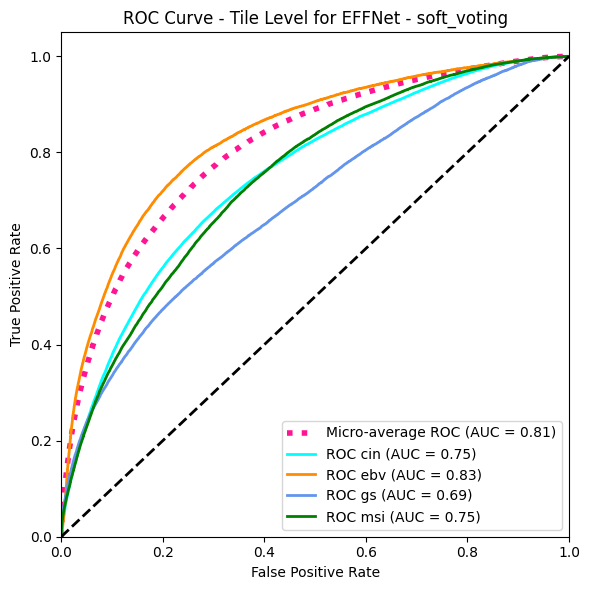

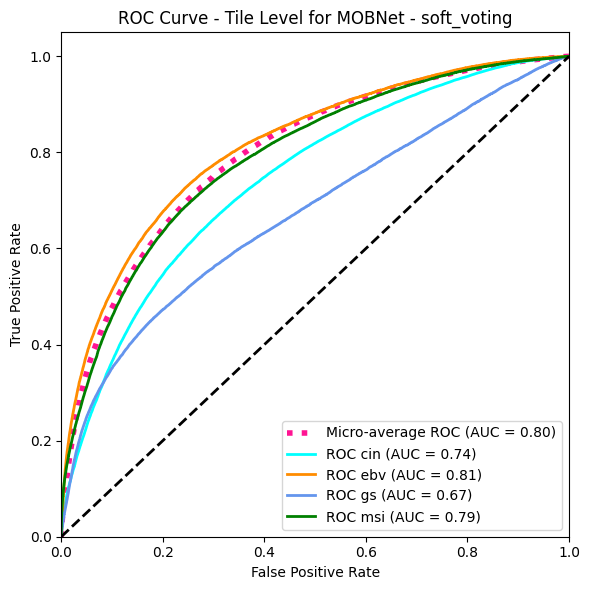

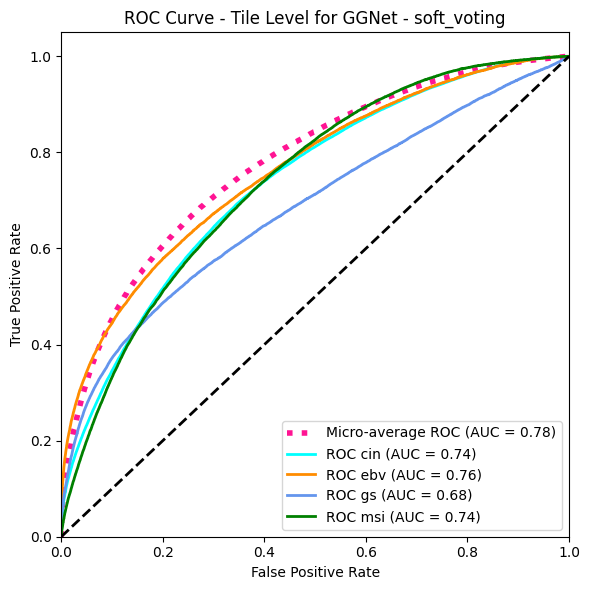

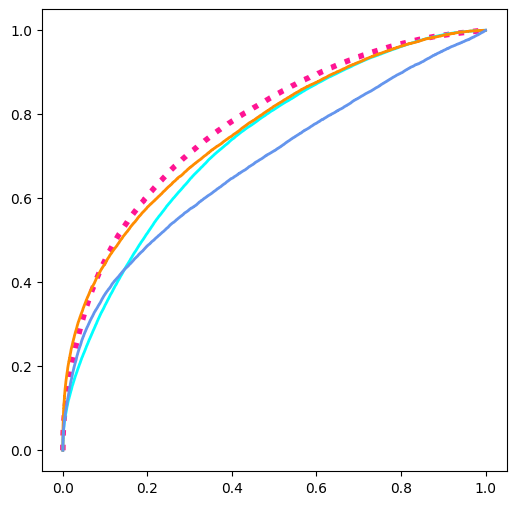

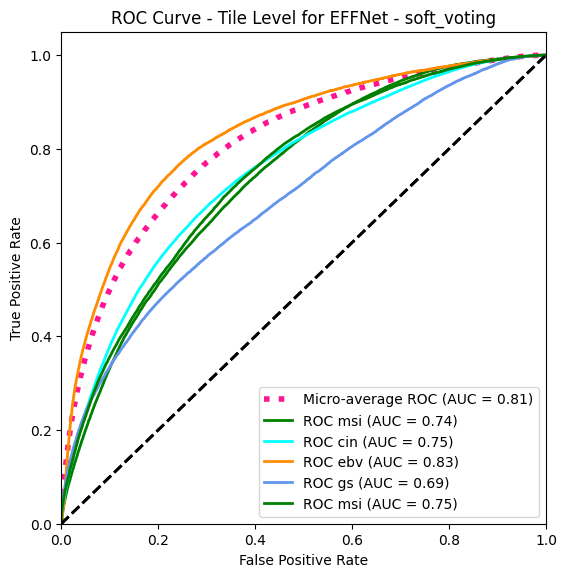

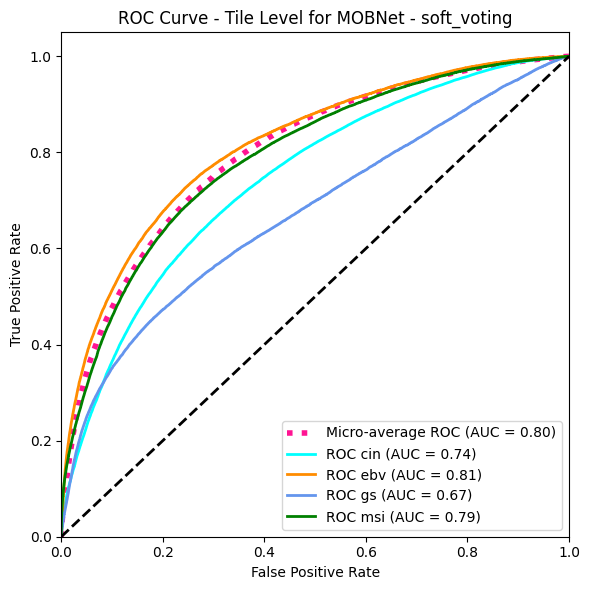

In [3]:
# =====================================================
# Geração Condicional das Tabelas de Predições (SA e MA)
# =====================================================
tables_dir, ensemble_between_base = resolve_paths_outputs()
ensure_datas_mirror()  # garante cópia dos CSVs de notebooks/ para datas/ quando aplicável

# ---------
# Preparar configurações de SA por modelo
# ---------
models_cfgs = []
log('[SA] - Descobrindo CSVs de folds por modelo...')
for m in tqdm(MODELS, desc='[SA] Descoberta de CSVs', leave=False):
    csvs = discover_model_csvs(m)
    models_cfgs.append({
        'model_name': m,
        'ensemble_type': ('weighted' if SA_ENSEMBLE_TYPE == 'weighted' else SA_ENSEMBLE_TYPE),
        'csv_paths': csvs,
        'save_output_base': os.path.join(tables_dir, m),
    })

# ---------
# Execução condicional do SA
# ---------
log('[SA] - Verificando artefatos existentes por nível (tile/image/patient)...')
cfgs_para_gerar = []
if REGENERATE_TABLES:
    cfgs_para_gerar = models_cfgs
else:
    for cfg in models_cfgs:
        ok, status = check_sa_ready(tables_dir, cfg['model_name'], SA_ENSEMBLE_TYPE, WEIGHT_METRIC)
        if ok:
            log(f"[SA] - Artefatos já existem para {cfg['model_name']} (todos os níveis). Pulando geração.")
        else:
            faltantes = [k for k, v in status.items() if not v]
            log(f"[SA] - Faltam arquivos para {cfg['model_name']}: {faltantes}. Agendando geração.")
            cfgs_para_gerar.append(cfg)

if cfgs_para_gerar:
    log(f"[SA] - Processando {len(cfgs_para_gerar)} modelo(s) com paralelização...")
    # Barra de progresso por modelo (atualiza ao finalizar cada tarefa)
    resultados_sa = run_sa_pipeline(cfgs_para_gerar)
    for cfg, res in tqdm(list(zip(cfgs_para_gerar, resultados_sa)), desc='[SA] Consolidação de resultados', leave=False):
        mname = cfg.get('model_name', 'modelo_desconhecido')
        # Trata erros retornados por tarefas paralelas (ex.: FileExistsError)
        if isinstance(res, Exception):
            log(f"[SA] - Erro ao processar {mname}: {type(res).__name__}: {res}")
            continue
        if not isinstance(res, dict):
            log(f"[SA] - Retorno inesperado para {mname}: {res}")
            continue
        for lvl in ['tile', 'image', 'patient']:
            info = res.get(lvl)
            if isinstance(info, dict):
                csv_path = info.get('csv')
                out_dir = info.get('out_dir')
                log(f"[SA] - Nível {lvl.capitalize()} | Modelo {mname} | CSV: {csv_path} | out_dir: {out_dir}")
            else:
                log(f"[SA] - Nível {lvl.capitalize()} | Modelo {mname} | [não gerado]")
    log('[✔] SA finalizado para modelos processados.')
else:
    log('[SA] - Nenhum modelo pendente. Geração de tabelas SA pulada.')

# ---------
# Execução condicional do MA
# ---------
def expected_ma_paths(ensemble_type: str, weight_metric: str) -> Dict[str, str]:
    # Diretórios por nível
    img_dir  = os.path.join(ensemble_between_base, f"ImageLevel_Ensemble_Models_{ensemble_type}")
    tile_dir = os.path.join(ensemble_between_base, f"TileLevel_Ensemble_Models_{ensemble_type}")
    pat_dir  = os.path.join(ensemble_between_base, f"PatientLevel_Ensemble_{ensemble_type}")
    # Arquivos de saída por nível (CSV/JSON) segundo modules/ensemble_between_models.py
    if ensemble_type == 'weighted':
        img_csv = os.path.join(img_dir,  f"ensemble_between_models_per_image_{ensemble_type}_{weight_metric}.csv")
        img_met = os.path.join(img_dir,  f"metrics_image_level_{ensemble_type}_{weight_metric}.json")
        tile_csv = os.path.join(tile_dir, f"ensemble_between_models_tile_level_{ensemble_type}.csv")
        tile_met = os.path.join(tile_dir, f"metrics_tile_level_{ensemble_type}_{weight_metric}.json")
        pat_csv = os.path.join(pat_dir,  f"ensemble_between_models_per_patient_{ensemble_type}_{weight_metric}.csv")
        pat_met = os.path.join(pat_dir,  f"global_metrics_patient_level_{ensemble_type}_{weight_metric}.json")
    else:
        img_csv = os.path.join(img_dir,  f"ensemble_between_models_per_image_{ensemble_type}.csv")
        img_met = os.path.join(img_dir,  f"metrics_image_level_{ensemble_type}.json")
        tile_csv = os.path.join(tile_dir, f"ensemble_between_models_tile_level_{ensemble_type}.csv")
        tile_met = os.path.join(tile_dir, f"metrics_tile_level_{ensemble_type}.json")
        pat_csv = os.path.join(pat_dir,  f"ensemble_between_models_per_patient_{ensemble_type}.csv")
        pat_met = os.path.join(pat_dir,  f"global_metrics_patient_level_{ensemble_type}.json")
    return {
        'image_csv': img_csv, 'image_metrics': img_met,
        'tile_csv': tile_csv,  'tile_metrics': tile_met,
        'patient_csv': pat_csv,'patient_metrics': pat_met,
    }

def check_ma_ready(ensemble_type: str, weight_metric: str) -> tuple[bool, Dict[str, bool]]:
    paths = expected_ma_paths(ensemble_type, weight_metric)
    status = {k: os.path.exists(v) for k, v in paths.items()}
    return all(status.values()), status

log('[MA] - Verificando artefatos existentes por nível (image/tile/patient)...')
ma_ok, ma_status = check_ma_ready(MA_ENSEMBLE_TYPE, WEIGHT_METRIC)
if ma_ok and not REGENERATE_TABLES:
    log('[MA] - Artefatos completos já existem. Pulando geração de tabelas MA.')
else:
    faltantes = [k for k, v in ma_status.items() if not v]
    log(f"[MA] - Faltam arquivos: {faltantes}. Iniciando ensemble entre modelos...")
    log(f"[MA] - Processando ensemble... tipo={MA_ENSEMBLE_TYPE} peso={WEIGHT_METRIC}")
    # Barra simples de 3 níveis (Image → Tile → Patient) apenas para visual
    run_between_models(MODELS, MA_ENSEMBLE_TYPE, WEIGHT_METRIC)
    log('[✔] MA finalizado.')


In [4]:
# =============================================
# Geração de Métricas e Visualizações (Indep.)
# =============================================
# Esta célula pode ser executada isoladamente caso as tabelas (SA/MA) já estejam prontas.
tables_dir, ensemble_between_base = resolve_paths_outputs()

# ---------
# Visualizações para SA (por modelo/nível)
# ---------
log('[SA] - Exportando artefatos e gerando plots para results/SA/...')
for m in tqdm(MODELS, desc='[SA] Export & Plots', leave=False):
    try:
        export_sa_to_results(tables_dir, m, SA_ENSEMBLE_TYPE, WEIGHT_METRIC)
    except Exception as e:
        log(f'[SA] - Aviso: falha ao exportar/plotar para {m}: {e}')

# ---------
# Visualizações para MA (por nível)
# ---------
log('[MA] - Exportando artefatos e gerando plots para results/MA/...')
# Recalcular paths esperados e exportar para results com geração de PNGs
def expected_ma_paths(ensemble_type: str, weight_metric: str) -> Dict[str, str]:
    img_dir  = os.path.join(ensemble_between_base, f"ImageLevel_Ensemble_Models_{ensemble_type}")
    tile_dir = os.path.join(ensemble_between_base, f"TileLevel_Ensemble_Models_{ensemble_type}")
    pat_dir  = os.path.join(ensemble_between_base, f"PatientLevel_Ensemble_{ensemble_type}")
    if ensemble_type == 'weighted':
        img_csv = os.path.join(img_dir,  f"ensemble_between_models_per_image_{ensemble_type}_{weight_metric}.csv")
        img_met = os.path.join(img_dir,  f"metrics_image_level_{ensemble_type}_{weight_metric}.json")
        tile_csv = os.path.join(tile_dir, f"ensemble_between_models_tile_level_{ensemble_type}.csv")
        tile_met = os.path.join(tile_dir, f"metrics_tile_level_{ensemble_type}_{weight_metric}.json")
        pat_csv = os.path.join(pat_dir,  f"ensemble_between_models_per_patient_{ensemble_type}_{weight_metric}.csv")
        pat_met = os.path.join(pat_dir,  f"global_metrics_patient_level_{ensemble_type}_{weight_metric}.json")
    else:
        img_csv = os.path.join(img_dir,  f"ensemble_between_models_per_image_{ensemble_type}.csv")
        img_met = os.path.join(img_dir,  f"metrics_image_level_{ensemble_type}.json")
        tile_csv = os.path.join(tile_dir, f"ensemble_between_models_tile_level_{ensemble_type}.csv")
        tile_met = os.path.join(tile_dir, f"metrics_tile_level_{ensemble_type}.json")
        pat_csv = os.path.join(pat_dir,  f"ensemble_between_models_per_patient_{ensemble_type}.csv")
        pat_met = os.path.join(pat_dir,  f"global_metrics_patient_level_{ensemble_type}.json")
    return {
        'image_csv': img_csv, 'image_metrics': img_met,
        'tile_csv': tile_csv,  'tile_metrics': tile_met,
        'patient_csv': pat_csv,'patient_metrics': pat_met,
    }

ma_paths = expected_ma_paths(MA_ENSEMBLE_TYPE, WEIGHT_METRIC)
# Exportar e gerar plots por nível (se arquivos existirem)
for level, (csv_key, met_key) in [('Image', ('image_csv','image_metrics')), ('Tile', ('tile_csv','tile_metrics')), ('Patient', ('patient_csv','patient_metrics'))]:
    csv_path = ma_paths[csv_key]
    met_path = ma_paths[met_key]
    if os.path.exists(csv_path):
        try:
            export_ma_to_results(MA_ENSEMBLE_TYPE, WEIGHT_METRIC, level, csv_path, met_path)
        except Exception as e:
            log(f'[MA] - Aviso: falha ao exportar/plotar {level}: {e}')
    else:
        log(f'[MA] - Aviso: CSV não encontrado para {level}: {csv_path}')

log('[✔] Métricas e visualizações geradas/copiedas para results/.')


[09:09:10] [SA] - Exportando artefatos e gerando plots para results/SA/...


[09:10:29] [MA] - Exportando artefatos e gerando plots para results/MA/...
[09:10:29] [MA] - Aviso: CSV não encontrado para Image: c:\Users\rodri\OneDrive - UFPE\Documentos\ensamble_pipeline_MA_SA_models\outputs\tables\Ensemble_Between_Models\ImageLevel_Ensemble_Models_soft_voting\ensemble_between_models_per_image_soft_voting.csv
[09:10:29] [MA] - Aviso: CSV não encontrado para Tile: c:\Users\rodri\OneDrive - UFPE\Documentos\ensamble_pipeline_MA_SA_models\outputs\tables\Ensemble_Between_Models\TileLevel_Ensemble_Models_soft_voting\ensemble_between_models_tile_level_soft_voting.csv
[09:10:29] [MA] - Aviso: CSV não encontrado para Patient: c:\Users\rodri\OneDrive - UFPE\Documentos\ensamble_pipeline_MA_SA_models\outputs\tables\Ensemble_Between_Models\PatientLevel_Ensemble_soft_voting\ensemble_between_models_per_patient_soft_voting.csv
[09:10:29] [✔] Métricas e visualizações geradas/copiedas para results/.
